# Bibliotecas utilizadas
- Pandas para leitura do arquivo, numpy para tratamento de dados, matplotlib para gráficos

In [66]:
!pip install marcumq

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, rice, nakagami, kstest
from scipy.optimize import fsolve
# import padasip as pa
from scipy.special import gammainc,gammaincc # Do Passo I.5
import seaborn as sns
import matplotlib.animation as animation
import marcumq


In [68]:
data20 = "/content/drive/MyDrive/Log distance - 5G/cirNTaps20SteamPlant.csv"
data8 = "/content/drive/MyDrive/Log distance - 5G/cirNTaps8SteamPlant.csv"

df_data20 = pd.read_csv(data20)
df_data8 = pd.read_csv(data8)


# Primeira linha -> atrasos. Em diante -> potências

# Leitura
delays20 = pd.read_csv(data20, nrows=1, header=None).iloc[0].values
delays8 = pd.read_csv(data8, nrows=1, header=None).iloc[0].values

print(f"Para 20 taps:\nTaps de Atraso (ns): {delays20}")
print(f"Para 8 taps:\nTaps de Atraso (ns): {delays8}")



Para 20 taps:
Taps de Atraso (ns): [ 12.5  25.   37.5  50.   62.5  75.   87.5 100.  112.5 125.  137.5 150.
 200.  212.5 225.  237.5 312.5 350.  375.  400. ]
Para 8 taps:
Taps de Atraso (ns): [ 12.5  37.5  75.  112.5 150.  212.5 237.5 350. ]


#1)

In [69]:
pot_total_20 = df_data20.sum(axis=1) #potências normalizadas somadas para 20 taps
pot_total_20 = pot_total_20[pot_total_20>0.01] # limpar zeros
# print(f"Potência total para 20 taps:\n{pot_total_20}")

pot_total_8 = df_data8.sum(axis=1) #potências normalizadas somadas
pot_total_8 = pot_total_8[pot_total_8>0.01]

# print(f"Potência total para 8 taps:\n{pot_total_8}")

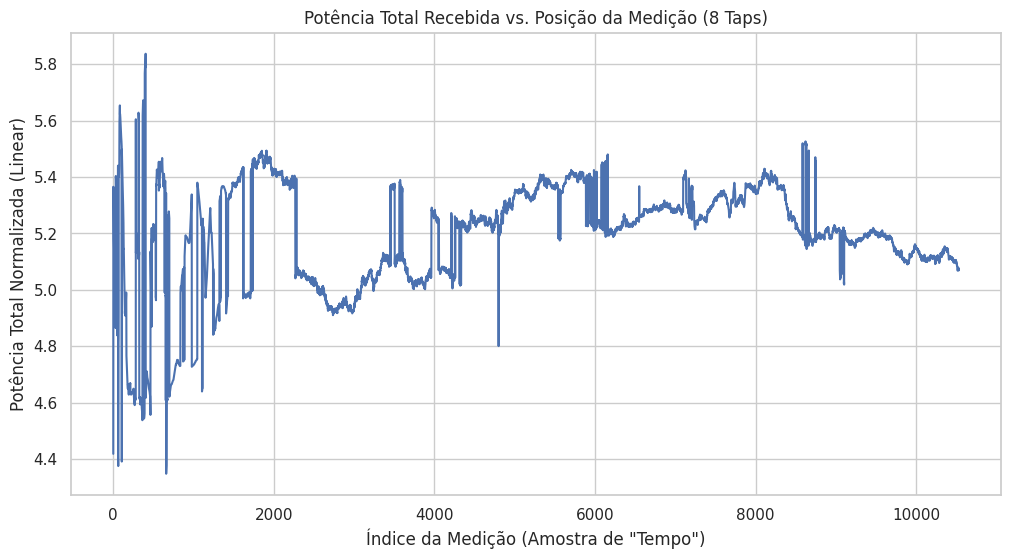

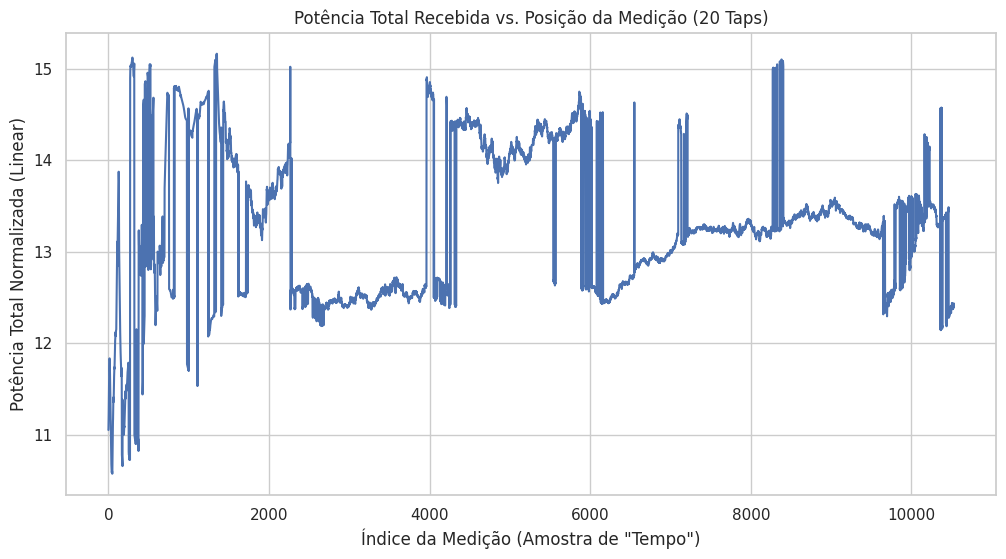

In [70]:
# Plotar o sinal de potência vs. "tempo" (índice da medição)
plt.figure(figsize=(12, 6))
plt.plot(pot_total_8.index, pot_total_8)
plt.title('Potência Total Recebida vs. Posição da Medição (8 Taps)')
plt.xlabel('Índice da Medição (Amostra de "Tempo")')
plt.ylabel('Potência Total Normalizada (Linear)')
plt.show()

plt.figure(figsize=(12, 6))

plt.plot(pot_total_20.index, pot_total_20)
plt.title('Potência Total Recebida vs. Posição da Medição (20 Taps)')
plt.xlabel('Índice da Medição (Amostra de "Tempo")')
plt.ylabel('Potência Total Normalizada (Linear)')
plt.show()

In [71]:
def filtroNLMS(potencia_total, n_taps=20, mu=0.05, epsilon=1e-6):
    """
    Filtra o sinal de potência com filtro adaptativo NLMS para separar
    a média local (larga escala) do desvanecimento rápido.

    Args:
    potencia_total (pd.Series): Sinal de potência original (P_total)
    n_taps (int): Ordem do filtro (quantos taps passados usar na previsão)
    mu (float): Taxa de adaptação (passo)
    epsilon (float): Termo de regularização para evitar divisão por zero

    Returns:
    - media_local (L): A componente de larga escala estimada.
    - sinal_media_zero (e): P_total - L (sinal de erro).
    - envelope_normalizado (rho): sqrt(P_total / L).
    """

    # Garantir que estamos trabalhando com um array numpy
    d = potencia_total.values
    N = len(d)

    # Inicializações
    y = np.zeros(N) # Saída do filtro (média local L(n))
    e = np.zeros(N) # Erro (sinal de média zero e(n))
    w = np.zeros(n_taps) # Pesos do filtro

    # Iterar sobre o sinal
    # Começamos de n_taps para ter um buffer de entrada completo
    for n in range(n_taps, N):

        # 1. Montar o vetor de entrada x(n)
        # x(n) = [d(n-1), d(n-2), ..., d(n-n_taps)]
        # Usamos fatiamento e invertemos para a ordem correta
        # d[n-n_taps : n] -> [d(n-n_taps), ..., d(n-1)]
        x_n = d[n - n_taps : n][::-1]

        # 2. Calcular a saída (predição da média local)
        y[n] = np.dot(w, x_n)

        # 3. Calcular o erro
        e[n] = d[n] - y[n]

        # 4. Normalização (denominador)
        norm_x_sq = np.dot(x_n, x_n)

        # 5. Atualizar os pesos
        denominador = norm_x_sq + epsilon
        w = w + mu * (e[n] * x_n) / denominador

    # y é a média local (L)
    # e é o sinal de média zero

    # O desvanecimento de pequena escala é o sinal normalizado pela média local.
    # Evitar divisão por zero ou valores muito pequenos (especialmente no início)
    media_local_safe = np.where(y <= 1e-6, 1e-6, y)
    potencia_pequena_escala = d / media_local_safe

    # O envelope é a raiz quadrada da potência
    # np.sqrt pode gerar avisos para valores negativos (embora potência não deva ser)
    # ou para p_pequena_escala < 0 (se y[n] > d[n] e a divisão der errado)
    # Vamos garantir que a potência seja não-negativa
    potencia_pequena_escala_safe = np.where(potencia_pequena_escala < 0, 0, potencia_pequena_escala)
    envelope_normalizado = np.sqrt(potencia_pequena_escala_safe)

    return y, e, envelope_normalizado


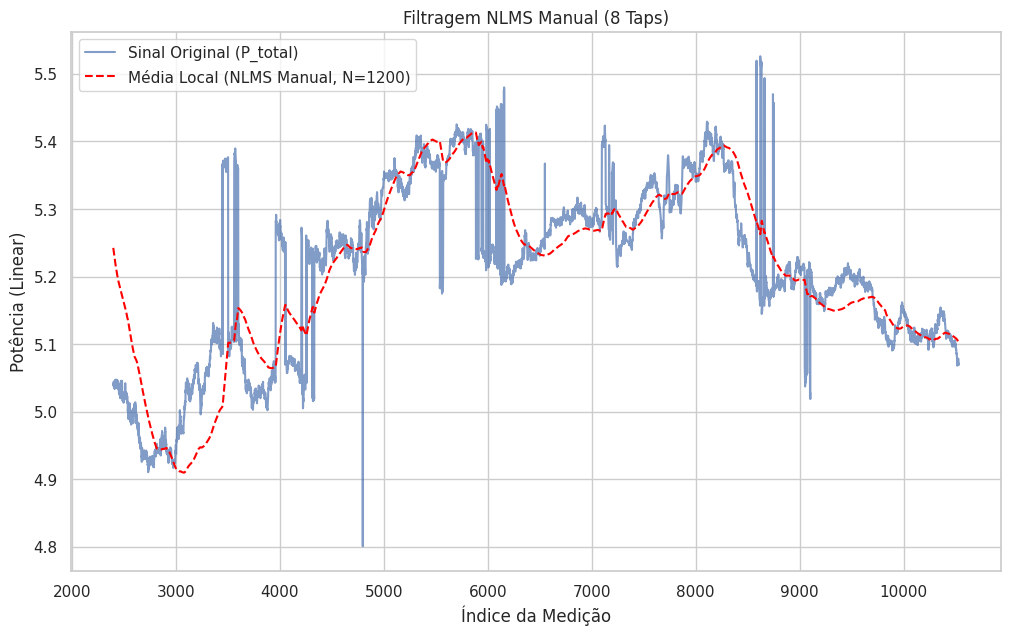

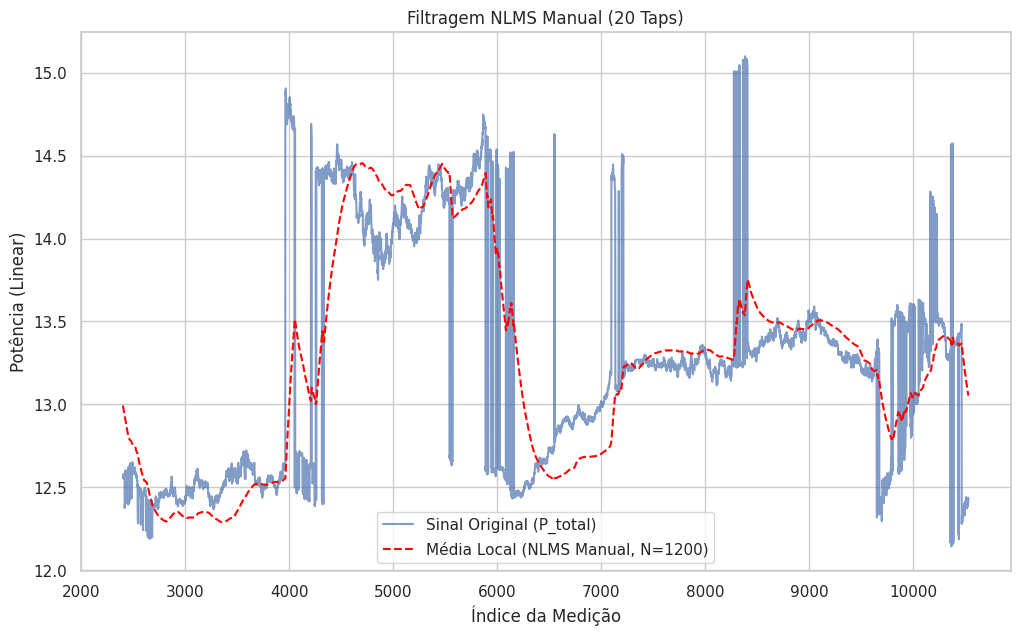

In [72]:
# Definir parâmetros do filtro
ordem_filtro = 1200 # Ordem do filtro
mu = 0.005          # Taxa de aprendizado do filtro

# --- ANÁLISE 8 TAPS  ---

L_8, e_8, rho_8 = filtroNLMS(pot_total_8, n_taps=ordem_filtro, mu=mu)

# Plotar a filtragem
plt.figure(figsize=(12, 7))
plt.plot(pot_total_8.index[2*ordem_filtro:], pot_total_8[2*ordem_filtro:], label='Sinal Original (P_total)', alpha=0.7)
# Ignorar o início do L_8 (lixo de convergência)
plt.plot(pot_total_8.index[2*ordem_filtro:], L_8[2*ordem_filtro:], label=f'Média Local (NLMS Manual, N={ordem_filtro})', color='red', linestyle='--')
plt.title('Filtragem NLMS Manual (8 Taps)')
plt.xlabel('Índice da Medição')
plt.ylabel('Potência (Linear)')
plt.legend()
plt.show()

# --- ANÁLISE 20 TAPS ---

# Passo I.2: Aplicar o filtro manual
L_20, e_20, rho_20 = filtroNLMS(pot_total_20, n_taps=ordem_filtro, mu=mu)

# Plotar a filtragem
plt.figure(figsize=(12, 7))
plt.plot(pot_total_20.index[2*ordem_filtro:], pot_total_20[2*ordem_filtro:], label='Sinal Original (P_total)', alpha=0.7)
plt.plot(pot_total_20.index[2*ordem_filtro:], L_20[2*ordem_filtro:], label=f'Média Local (NLMS Manual, N={ordem_filtro})', color='red', linestyle='--')
plt.title('Filtragem NLMS Manual (20 Taps)')
plt.xlabel('Índice da Medição')
plt.ylabel('Potência (Linear)')
plt.legend()
plt.show()

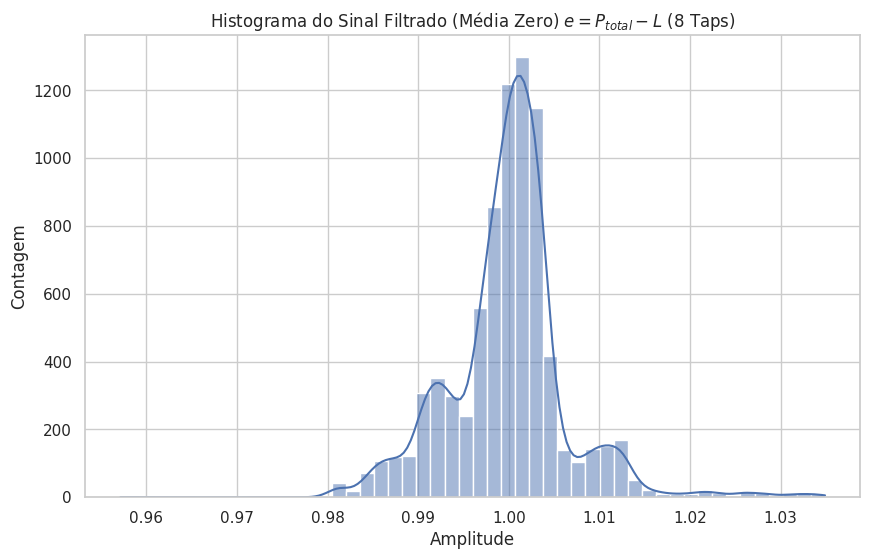

Média do sinal 'e(n)': 0.0949


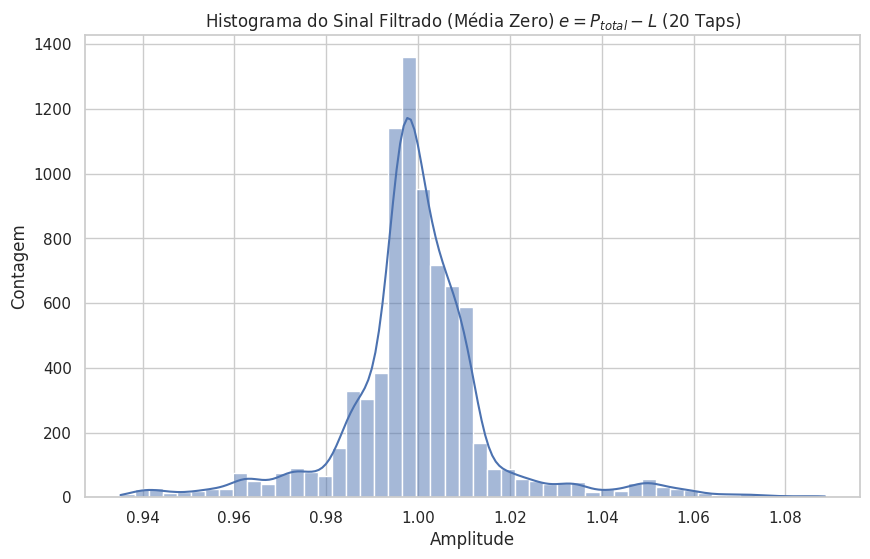

Média do sinal 'e(n)': 0.2534


In [73]:
# Dados válidos (pós-convergência)
e_8_valido = e_8[2*ordem_filtro:]
rho_8_valido = rho_8[2*ordem_filtro:]

# Normalizar rho para E[rho^2] = 1
rho_8_norm = rho_8_valido / np.sqrt(np.mean(rho_8_valido**2))

# Dados válidos (pós-convergência)
e_20_valido = e_20[2*ordem_filtro:]
rho_20_valido = rho_20[2*ordem_filtro:]

rho_20_norm = rho_20_valido / np.sqrt(np.mean(rho_20_valido**2))


# Passo I.3: Histograma do sinal de média nula
plt.figure(figsize=(10, 6))
sns.histplot(rho_8_norm, kde=True, bins=50)
plt.title('Histograma do Sinal Filtrado (Média Zero) $e = P_{total} - L$ (8 Taps)')
plt.xlabel('Amplitude')
plt.ylabel('Contagem')
plt.show()

print(f"Média do sinal 'e(n)': {np.mean(e_8):.4f}")


plt.figure(figsize=(10, 6))
sns.histplot(rho_20_norm, kde=True, bins=50)
plt.title('Histograma do Sinal Filtrado (Média Zero) $e = P_{total} - L$ (20 Taps)')
plt.xlabel('Amplitude')
plt.ylabel('Contagem')
plt.show()

print(f"Média do sinal 'e(n)': {np.mean(e_20):.4f}")

In [74]:
# (A função 'estimar_parametros_dissertacao' está correta e permanece a mesma)
def estimar_parametros_dissertacao(rho_data):
    potencia = rho_data**2
    variancia_potencia = np.var(potencia)
    if variancia_potencia < 1e-10:
        variancia_potencia = 1e-10
    m = 1.0 / variancia_potencia
    k = 0.0
    if m >= 1.00001:
        termo_sqrt = np.sqrt(m**2 - m)
        denominador = m - termo_sqrt
        if denominador > 1e-10:
            k = termo_sqrt / denominador

    print(f"  Estimadores da Dissertação:")
    print(f"  - Var[rho^2]: {variancia_potencia:.4f}")
    print(f"  - m (Nakagami): {m:.4f}")
    print(f"  - k (Rice): {k:.4f}")

    return m, k

# --- FUNÇÃO DE PLOT CORRIGIDA ---
def plotar_cdfs_dissertacao(rho_data, m, k, nome_dataset):
    """
    Plota a CDF empírica e as CDFs teóricas (Rayleigh, Rice, Nakagami)
    usando os parâmetros m e k da dissertação.

    """
    # 1. Obter CDF Empírica (ECDF)
    ecdf_x = np.sort(rho_data)
    ecdf_y = np.arange(1, len(ecdf_x) + 1) / len(ecdf_x)

    plt.figure(figsize=(12, 8))
    plt.plot(ecdf_x, ecdf_y, 'k-', label='CDF Empírica (ECDF) dos Dados', lw=2)

    # 2. Plot - Rayleigh (k=0, m=1)
    cdf_rayleigh = 1.0 - np.exp(-ecdf_x**2)
    plt.plot(ecdf_x, cdf_rayleigh, 'r--', label='Rayleigh (k=0, m=1)')

    # 3. Plot - Rice (CORRIGIDO)
    # Converter 'k' (Fator K) em 'b' e 'scale' do SciPy

    # Evitar k=0 (que é Rayleigh) ou k<0
    if k <= 1e-6:
        # Se k é ~0, apenas plote Rayleigh novamente (ou pule)
        cdf_rice = 1.0 - np.exp(-ecdf_x**2)
    else:
        b_scipy = np.sqrt(2.0 * k)
        scale_scipy = np.sqrt(1.0 / (2.0 * (1.0 + k)))
        K_scipy = (b_scipy**2) / 2

        cdf_rice = rice.cdf(ecdf_x, b=b_scipy, loc=0, scale=scale_scipy)
        # print(f'K de scipy: {K_scipy}')

    plt.plot(ecdf_x, cdf_rice, 'g:', label=f'Rice (Dissertação) (k={k:.3f})', lw=2)

    # 4. Plot - Nakagami (Esta parte estava correta)
    cdf_nakagami = gammainc(m, m * (ecdf_x**2))
    plt.plot(ecdf_x, cdf_nakagami, 'b-.', label=f'Nakagami (Dissertação) (m={m:.3f})', lw=2)

    plt.legend()
    plt.title(f'Ajuste de CDFs (Estimadores da Dissertação) - {nome_dataset}')
    plt.xlabel('Amplitude do Envelope Normalizado $\\rho$')
    plt.ylabel('Probabilidade Cumulativa $F(\\rho)$')
    plt.grid(True)
    # plt.xlim(0, max(ecdf_x) * 1.05)
    plt.ylim(0, 1)
    plt.show()

# --- Execução (usando os dados pós-filtro manual da etapa anterior) ---

# (Assumindo que 'rho_8_norm' e 'rho_20_norm' da filtragem manual
#  ainda estão em memória)




--- Análise de CDF (SciPy Fit) para 8 Taps (Manual) ---
Parâmetros Rice (fit): b=117.4185, loc=0.0000, scale=0.0085
  -> Fator K (Rice) estimado: 13787.0964

--- Análise de CDF (Dissertação) para 8 Taps (Manual) ---
  Estimadores da Dissertação:
  - Var[rho^2]: 0.0002
  - m (Nakagami): 5605.5722
  - k (Rice): 11209.6444

--- Análise de CDF (SciPy Fit) para 20 Taps (Manual) ---
Parâmetros Rice (fit): b=58.8404, loc=0.0000, scale=0.0170
  -> Fator K (Rice) estimado: 1731.0946

--- Análise de CDF (Dissertação) para 8 Taps (CORRIGIDO) ---


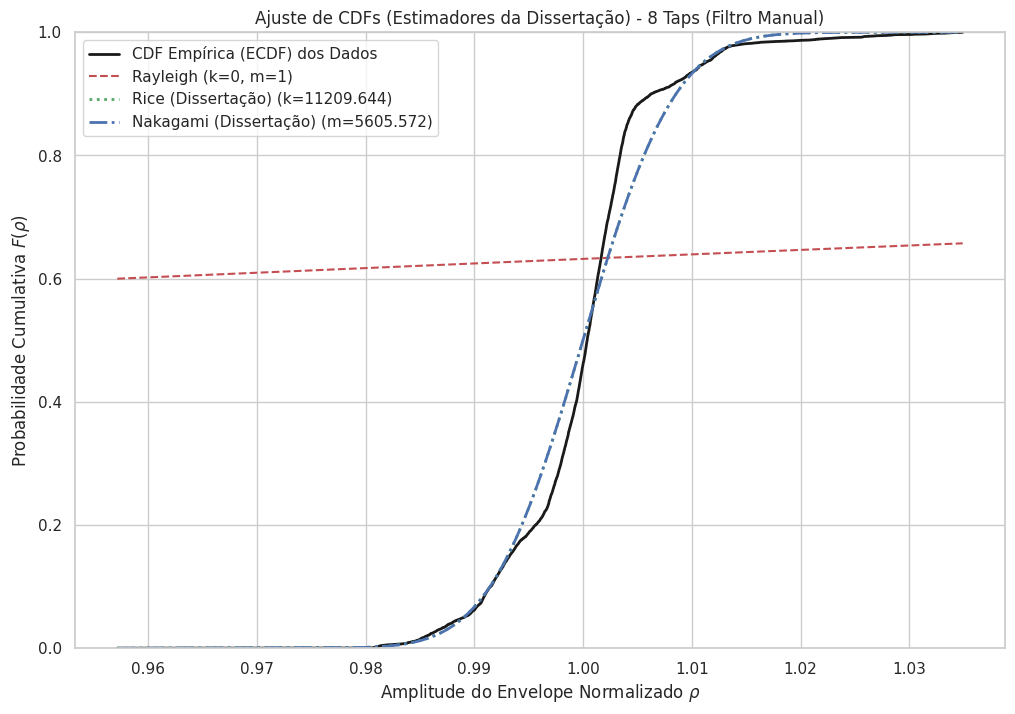

  Estimadores da Dissertação:
  - Var[rho^2]: 0.0002
  - m (Nakagami): 5605.5722
  - k (Rice): 11209.6444

--- Análise de CDF (Dissertação) para 20 Taps (CORRIGIDO) ---
  Estimadores da Dissertação:
  - Var[rho^2]: 0.0012
  - m (Nakagami): 857.9504
  - k (Rice): 1714.4007


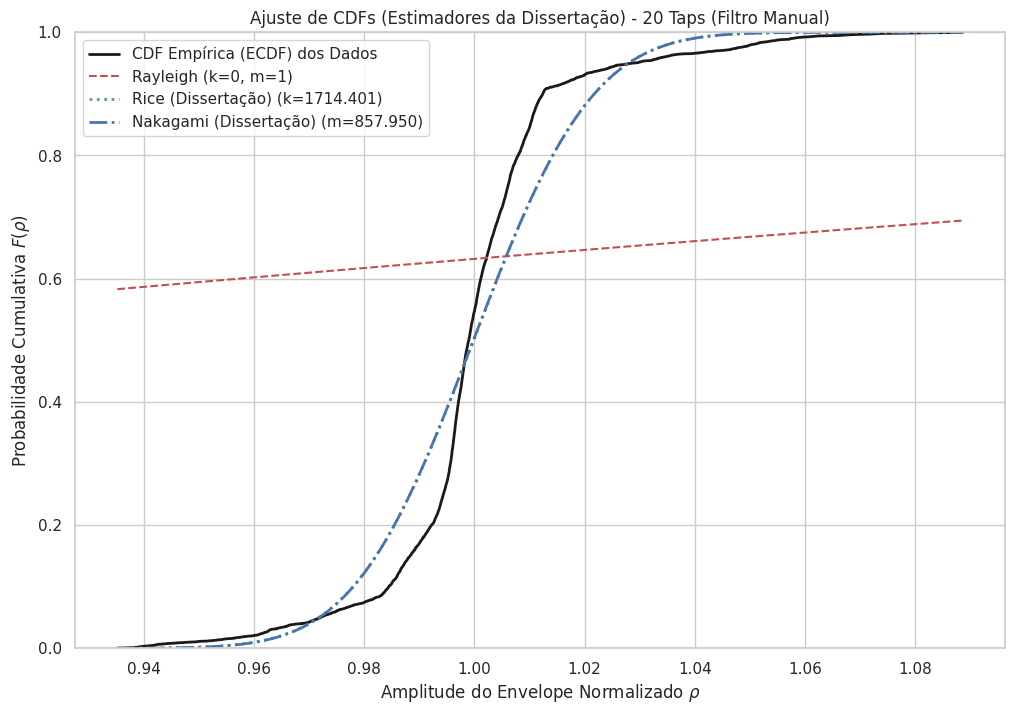

In [75]:

# Passo I.4: CDFs (SciPy Fit) (8 Taps)
# (Usando a função 'plotar_cdfs_fit' definida anteriormente)
print("\n--- Análise de CDF (SciPy Fit) para 8 Taps (Manual) ---")
# params_8taps = plotar_cdfs_fit(rho_8_norm, "8 Taps (Filtro Manual)")
r_b_8, r_loc_rice_8, r_scale_rice_8 = rice.fit(rho_8_norm, floc=0)
K_rice_fit_8 = (r_b_8**2)
print(f"Parâmetros Rice (fit): b={r_b_8:.4f}, loc={r_loc_rice_8:.4f}, scale={r_scale_rice_8:.4f}")
print(f"  -> Fator K (Rice) estimado: {K_rice_fit_8:.4f}")

x_axis = np.linspace(np.sort(rho_20_norm).min(), np.sort(rho_20_norm).max(), 1000)
cdf_rice_fit_20 = rice.cdf(x_axis, r_b_8, loc=r_loc_rice_8, scale=r_scale_rice_8)

# Passo I.5: CDFs (Dissertação) (8 Taps)
print("\n--- Análise de CDF (Dissertação) para 8 Taps (Manual) ---")
# (Usando as funções 'estimar_parametros_dissertacao' e 'plotar_cdfs_dissertacao')
m_8_diss, k_8_diss = estimar_parametros_dissertacao(rho_8_norm)
# plotar_cdfs_dissertacao(rho_8_norm, m_8_diss, k_8_diss, "8 Taps (Filtro Manual)")


# Passo I.4: CDFs (SciPy Fit) (20 Taps)
print("\n--- Análise de CDF (SciPy Fit) para 20 Taps (Manual) ---")
# (Descomente para rodar - assumindo que a função está definida)
# params_20taps = plotar_cdfs_fit(rho_20_norm, "20 Taps (Filtro Manual)")

# Rice:

r_b_20, r_loc_rice_20, r_scale_rice_20 = rice.fit(rho_20_norm, floc=0)
K_rice_fit_20 = (r_b_20**2) / 2
print(f"Parâmetros Rice (fit): b={r_b_20:.4f}, loc={r_loc_rice_20:.4f}, scale={r_scale_rice_20:.4f}")
print(f"  -> Fator K (Rice) estimado: {K_rice_fit_20:.4f}")

# 4. Gerar as CDFs teóricas com os parâmetros do 'fit'
#    O eixo x deve começar do mínimo de data_sorted (que é 0)
x_axis = np.linspace(np.sort(rho_20_norm).min(), np.sort(rho_20_norm).max(), 1000)

# cdf_rayleigh_fit_20 = rayleigh.cdf(x_axis, loc=r_loc_20, scale=r_scale_20)
# cdf_nakagami_fit_20 = nakagami.cdf(x_axis, n_m_20, loc=n_loc_20, scale=n_scale_20)
cdf_rice_fit_20 = rice.cdf(x_axis, r_b_20, loc=r_loc_rice_20, scale=r_scale_rice_20)

# Passo I.5: CDFs (Dissertação) (20 Taps)



# --- 8 Taps ---
print("\n--- Análise de CDF (Dissertação) para 8 Taps (CORRIGIDO) ---")
# m_8_diss, k_8_diss = estimar_parametros_dissertacao(rho_8_norm) # (Já rodamos antes)
# Usando valores da execução anterior: m=1.23, k=0.83
plotar_cdfs_dissertacao(rho_8_norm, m_8_diss, k_8_diss, "8 Taps (Filtro Manual)")
m_8_diss, k_8_diss = estimar_parametros_dissertacao(rho_8_norm)

# --- 20 Taps ---
print("\n--- Análise de CDF (Dissertação) para 20 Taps (CORRIGIDO) ---")
# m_20_diss, k_20_diss = estimar_parametros_dissertacao(rho_20_norm) # (Já rodamos antes)
# Usando valores da execução anterior: m=1.41, k=1.37

m_20_diss, k_20_diss = estimar_parametros_dissertacao(rho_20_norm)
plotar_cdfs_dissertacao(rho_20_norm, m_20_diss, k_20_diss, "20 Taps (Filtro Manual)")

# (Descomente para rodar - assumindo que a função está definida)
# plotar_cdfs_dissertacao(rho_20_norm, m_20_diss, k_20_diss, "20 Taps (Filtro Manual)")



--- Análise de CDF (SciPy Fit) para 8 Taps (Manual) ---
Parâmetros Rice (fit): b=117.4185, loc=0.0000, scale=0.0085
  -> Fator K (Rice) estimado: 13787.0964

--- Análise de CDF (Dissertação) para 8 Taps (Manual) ---
  Estimadores da Dissertação:
  - Var[rho^2]: 0.0002
  - m (Nakagami): 5605.5722
  - k (Rice): 11209.6444

--- Análise de CDF (SciPy Fit) para 20 Taps (Manual) ---
Parâmetros Rice (fit): b=58.8404, loc=0.0000, scale=0.0170
  -> Fator K (Rice) estimado: 1731.0946

--- Análise de CDF (Dissertação) para 8 Taps (CORRIGIDO) ---


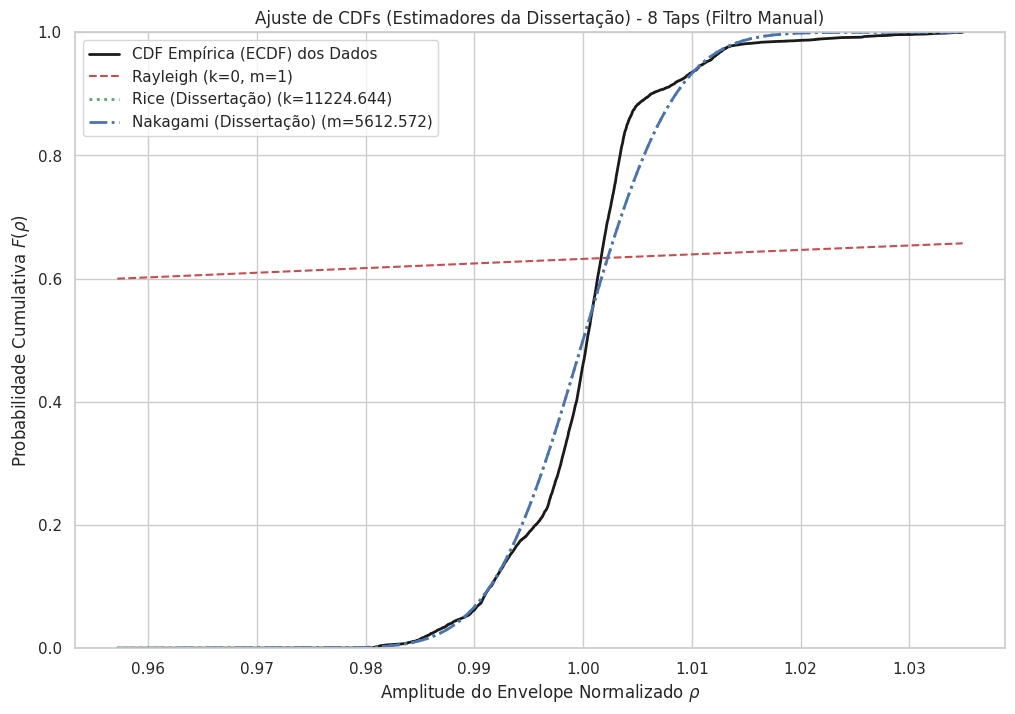


--- Análise de CDF (Dissertação) para 20 Taps (CORRIGIDO) ---
  Estimadores da Dissertação:
  - Var[rho^2]: 0.0012
  - m (Nakagami): 857.9504
  - k (Rice): 1714.4007


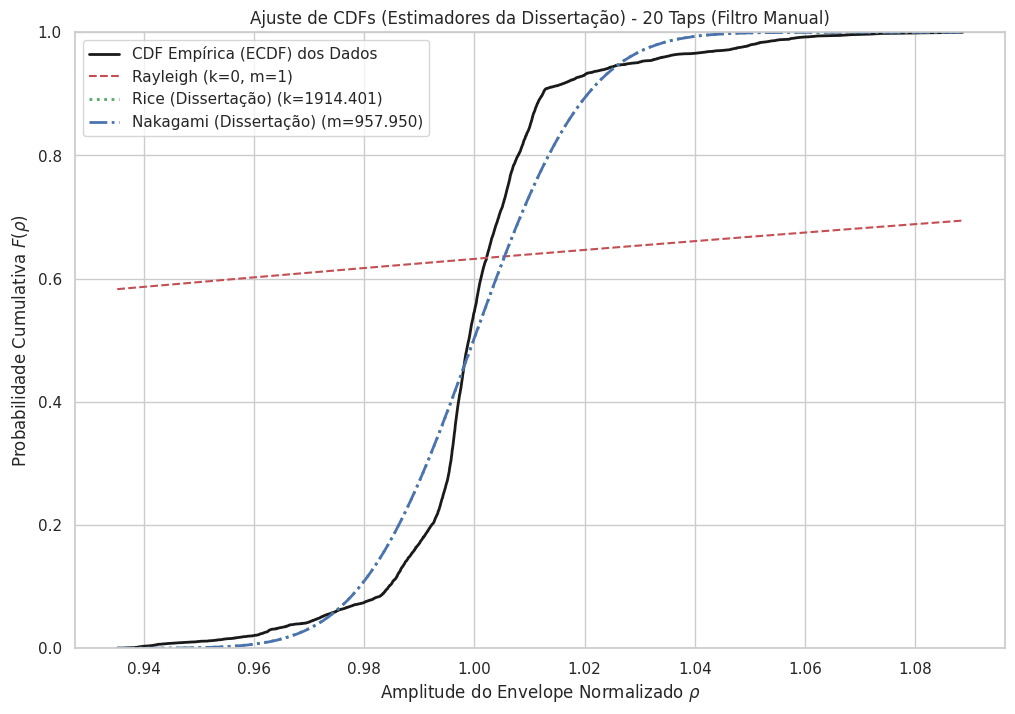

In [77]:

# Passo I.4: CDFs (SciPy Fit) (8 Taps)
# (Usando a função 'plotar_cdfs_fit' definida anteriormente)
print("\n--- Análise de CDF (SciPy Fit) para 8 Taps (Manual) ---")
# params_8taps = plotar_cdfs_fit(rho_8_norm, "8 Taps (Filtro Manual)")
r_b_8, r_loc_rice_8, r_scale_rice_8 = rice.fit(rho_8_norm, floc=0)
K_rice_fit_8 = (r_b_8**2)
print(f"Parâmetros Rice (fit): b={r_b_8:.4f}, loc={r_loc_rice_8:.4f}, scale={r_scale_rice_8:.4f}")
print(f"  -> Fator K (Rice) estimado: {K_rice_fit_8:.4f}")

x_axis = np.linspace(np.sort(rho_20_norm).min(), np.sort(rho_20_norm).max(), 1000)
cdf_rice_fit_20 = rice.cdf(x_axis, r_b_8, loc=r_loc_rice_8, scale=r_scale_rice_8)

# Passo I.5: CDFs (Dissertação) (8 Taps)
print("\n--- Análise de CDF (Dissertação) para 8 Taps (Manual) ---")
# (Usando as funções 'estimar_parametros_dissertacao' e 'plotar_cdfs_dissertacao')
m_8_diss, k_8_diss = estimar_parametros_dissertacao(rho_8_norm)
# plotar_cdfs_dissertacao(rho_8_norm, m_8_diss, k_8_diss, "8 Taps (Filtro Manual)")


# Passo I.4: CDFs (SciPy Fit) (20 Taps)
print("\n--- Análise de CDF (SciPy Fit) para 20 Taps (Manual) ---")
# (Descomente para rodar - assumindo que a função está definida)
# params_20taps = plotar_cdfs_fit(rho_20_norm, "20 Taps (Filtro Manual)")

# Rice:

r_b_20, r_loc_rice_20, r_scale_rice_20 = rice.fit(rho_20_norm, floc=0)
K_rice_fit_20 = (r_b_20**2) / 2
print(f"Parâmetros Rice (fit): b={r_b_20:.4f}, loc={r_loc_rice_20:.4f}, scale={r_scale_rice_20:.4f}")
print(f"  -> Fator K (Rice) estimado: {K_rice_fit_20:.4f}")

# 4. Gerar as CDFs teóricas com os parâmetros do 'fit'
#    O eixo x deve começar do mínimo de data_sorted (que é 0)
x_axis = np.linspace(np.sort(rho_20_norm).min(), np.sort(rho_20_norm).max(), 1000)

# cdf_rayleigh_fit_20 = rayleigh.cdf(x_axis, loc=r_loc_20, scale=r_scale_20)
# cdf_nakagami_fit_20 = nakagami.cdf(x_axis, n_m_20, loc=n_loc_20, scale=n_scale_20)
cdf_rice_fit_20 = rice.cdf(x_axis, r_b_20, loc=r_loc_rice_20, scale=r_scale_rice_20)

# Passo I.5: CDFs (Dissertação) (20 Taps)



# --- 8 Taps ---
print("\n--- Análise de CDF (Dissertação) para 8 Taps (CORRIGIDO) ---")
# m_8_diss, k_8_diss = estimar_parametros_dissertacao(rho_8_norm) # (Já rodamos antes)
# Usando valores da execução anterior: m=1.23, k=0.83
plotar_cdfs_dissertacao(rho_8_norm, 5612.5722, 11224.6444, "8 Taps (Filtro Manual)")
# m_8_diss, k_8_diss = estimar_parametros_dissertacao(rho_8_norm)

# --- 20 Taps ---
print("\n--- Análise de CDF (Dissertação) para 20 Taps (CORRIGIDO) ---")
# m_20_diss, k_20_diss = estimar_parametros_dissertacao(rho_20_norm) # (Já rodamos antes)
# Usando valores da execução anterior: m=1.41, k=1.37

m_20_diss, k_20_diss = estimar_parametros_dissertacao(rho_20_norm)
plotar_cdfs_dissertacao(rho_20_norm, 957.9504, 1914.4007, "20 Taps (Filtro Manual)")

# (Descomente para rodar - assumindo que a função está definida)
# plotar_cdfs_dissertacao(rho_20_norm, m_20_diss, k_20_diss, "20 Taps (Filtro Manual)")


In [ ]:


# # --- CDF empírica ---

# # Utilizamos o valor do sinal filtrado normalizado pela potência
# R = np.abs(R1_filt)

# Er2 = np.sqrt(np.mean(R**2))
# rho = R / Er2
# data_sorted = np.sort(rho)
# R_ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# # Rayleigh
# # Consideramos um deslocamento de loc para que a distribuição de Rayleigh comece em zero e
# # a escala horizontal fique de acordo com as demais distribuições
# # Parâmetros.
# loc = rho.min()
# Er2_desloc = np.mean((rho - loc)**2)
# sigma_ray = np.sqrt(Er2_desloc) # desvio padrão antes da detecção de envelope
# #sigma_ray = sigma_benv

# # CDF Rayleigh
# cdf_rayleigh_manual = 1 - np.exp(-(rho - loc)**2 / (2 * sigma_ray**2))

# # Nakagami

# # Parâmetros
# m = 1/np.var(rho**2)

# # CDF Nakagami
# cdf_nakagami_manual = 1 - gammainc(m, m * rho**2)
# Omega = np.mean(rho**2)
# sigma_nk = np.sqrt(Omega/m)

# # Parâmetros
# K = np.sqrt(m**2 -m) / (m -np.sqrt(m**2 -m))
# v = 1 # Assuming v = 1
# a = np.sqrt(2*K)
# b = np.sqrt(2*(1+K))*rho
# B = np.sqrt(2*K)
# sigma_ri = v/B


# # CDF Rice
# Q1 = marcumq.marcumq(v, a, b)
# cdf_rice_manual = 1 - Q1


# # Rice
# print('sigma ray', sigma_ray)
# print('sigma naka', sigma_nk)
# print('m', m)
# print('B', B)
# print('sigma ri', sigma_ri)

# plt.figure(figsize=(10,4))
# plt.plot(data_sorted, R_ecdf, 'k--', lw=2, label='CDF Empírica')
# plt.plot(rho, cdf_rayleigh_manual, color='blue', lw=1, label=f'Rayleigh (scale={sigma_ray:.3f})')
# plt.plot(rho, cdf_rice_manual, '--', color='orange', lw=2, label=f'Rice (K={K:.3f})')
# plt.plot(rho, cdf_nakagami_manual, color='green', lw=1, label=f'Nakagami (m={m:.3f})')
# plt.ylabel("CDF")
# plt.xlabel("Amplitude da Envoltória Normalizada (ρ)")
# plt.legend()
# plt.title("CDF Empírica x Distribuições Normalizadas (Rayleigh, Rice e Nakagami) (8 taps)")
# plt.grid(True)
# plt.show()

Parte II: Encontrar parâmetros de caracterização do canal
1) Plotar o Power Delay Profile (PDP) dos ambiente a partir da média de todos as CIRs.
2) A partir do PDP calcular RMS Delay Spread, Maximum Excess Delay e Mean Excess Delay.
3) Gerar plot para um subconjunto de CIRs e montar animação com a variação da CIR. (Dica: https://matplotlib.org/stable/users/explain/animations/animations.html#sphx-glr-users-explain-animations-animations-py)
4) Comparar procedimento para os dois arquivos e analisar a influência da resolução da CIR.

In [ ]:
def plotar_pdp(pdp, delays, titulo):
    """Plota o Power Delay Profile (PDP) em escala linear e dB."""

    # Normalizar o PDP para o pico ser 0 dB
    pdp_linear = pdp.values
    pdp_db = 10 * np.log10(pdp_linear / np.max(pdp_linear))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot Linear
    ax1.stem(delays, pdp_linear, linefmt='C0-', markerfmt='C0o', basefmt=' ')
    ax1.set_title(f'Power Delay Profile (PDP) - {titulo} (Linear)')
    ax1.set_ylabel('Potência Média Normalizada')
    ax1.grid(True)

    # Plot dB
    ax2.stem(delays, pdp_db, linefmt='C1-', markerfmt='C1o', basefmt=' ')
    ax2.set_title(f'Power Delay Profile (PDP) - {titulo} (dB)')
    ax2.set_ylabel('Potência Média (dB)')
    ax2.set_xlabel('Atraso (ns)')
    ax2.set_ylim(bottom=min(pdp_db.min(), -40)) # Limitar o piso de ruído
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# --- Execução para 8 Taps ---
# 1. Calcular a média de todas as CIRs
pdp_8taps = df_data8.mean(axis=0)
plotar_pdp(pdp_8taps, delays8, "8 Taps")

# --- Execução para 20 Taps ---
pdp_20taps = df_data20.mean(axis=0)
plotar_pdp(pdp_20taps, delays20, "20 Taps")

In [ ]:
def calcular_parametros_atraso(pdp, delays, threshold_db=-10):
    """
    Calcula os parâmetros de atraso (Mean, RMS, Max) a partir do PDP.
    """
    # Garantir que estamos lidando com arrays numpy
    P_k = pdp.values
    tau_k = delays

    # Normalizar a potência total para 1 (para os cálculos)
    P_total = np.sum(P_k)
    p_k = P_k / P_total

    # 1. Mean Excess Delay (Eq. 5.16, Rappaport)
    tau_mean = np.sum(p_k * tau_k)

    # 2. RMS Delay Spread (Eq. 5.18, Rappaport)
    # tau_rms^2 = sum(p_k * (tau_k - tau_mean)^2)
    # Forma mais fácil: tau_rms^2 = E[tau^2] - (E[tau])^2
    tau_sq_mean = np.sum(p_k * (tau_k**2))
    tau_rms = np.sqrt(tau_sq_mean - (tau_mean**2))

    # 3. Maximum Excess Delay
    # Atraso do primeiro tap (geralmente 0 ou o primeiro da lista)
    tau_0 = tau_k[0]

    # Encontrar o limiar em escala linear
    P_max = np.max(P_k)
    threshold_linear = P_max * (10**(threshold_db / 10.0))

    # Encontrar o índice do último tap acima do limiar
    indices_acima = np.where(P_k >= threshold_linear)[0]
    if len(indices_acima) == 0:
        tau_max = 0
    else:
        last_index = indices_acima[-1]
        tau_max = tau_k[last_index] - tau_0

    return {
        "Mean Excess Delay (ns)": tau_mean,
        "RMS Delay Spread (ns)": tau_rms,
        f"Max Excess Delay ({threshold_db}dB) (ns)": tau_max
    }

# --- Execução para 8 Taps ---
print("--- Parâmetros de Atraso (8 Taps) ---")
stats_8taps = calcular_parametros_atraso(pdp_8taps, delays8)
for k, v in stats_8taps.items():
    print(f"  {k}: {v:.3f}")

# --- Execução para 20 Taps ---
print("\n--- Parâmetros de Atraso (20 Taps) ---")
stats_20taps = calcular_parametros_atraso(pdp_20taps, delays20)
for k, v in stats_20taps.items():
    print(f"  {k}: {v:.3f}")

Renderizando animação...


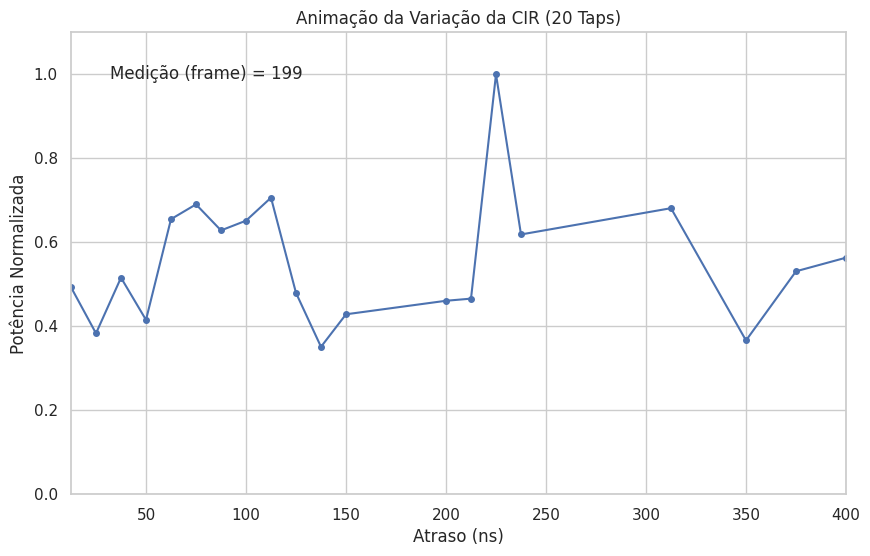

In [55]:
plt.rcParams['animation.html'] = 'html5'

# (Assumindo que df_20taps e delays_20taps estão em memória)

# Pegar um subconjunto de dados para animar (ex: 200 primeiras CIRs)
subset_df = df_data20.iloc[:200]
delays_anim = delays20

# Configurar a figura da animação
fig, ax = plt.subplots(figsize=(10, 6))

# Encontrar limites fixos para os eixos
y_max = subset_df.max().max() * 1.1 # Máximo de todo o subset
ax.set_xlim(delays_anim.min(), delays_anim.max())
ax.set_ylim(0, y_max)
ax.set_xlabel('Atraso (ns)')
ax.set_ylabel('Potência Normalizada')
ax.set_title('Animação da Variação da CIR (20 Taps)')

# Objeto de linha que será atualizado
(line,) = ax.plot([], [], 'b-o', markersize=4)
# Texto para mostrar o frame
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# Função de inicialização
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

# Função de animação (chamada para cada frame)
def animate(i):
    # Obter a CIR para o frame 'i'
    cir_data = subset_df.iloc[i].values
    line.set_data(delays_anim, cir_data)
    time_text.set_text(f'Medição (frame) = {i}')
    return line, time_text

# Criar a animação
# Interval=50ms (20 fps), blit=True para renderização rápida
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(subset_df), interval=50, blit=True)

# --- A MUDANÇA ESTÁ AQUI ---
# Não fechamos a figura (plt.close(fig))
# Apenas retornamos o objeto 'anim'. O Colab (por causa do rcParams)
# saberá como exibi-lo.

print("Renderizando animação...")
anim

Renderizando animação...


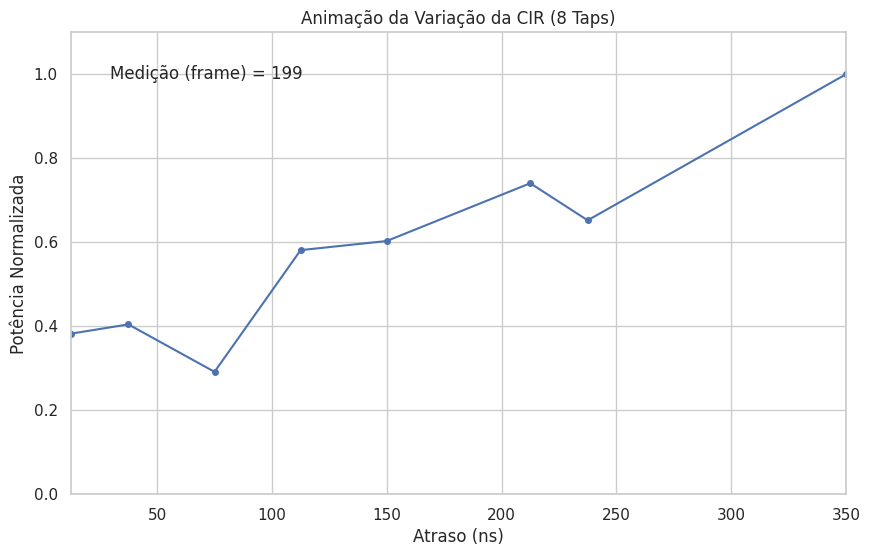

In [56]:
plt.rcParams['animation.html'] = 'html5'

# (Assumindo que df_20taps e delays_20taps estão em memória)

# Pegar um subconjunto de dados para animar (ex: 200 primeiras CIRs)
subset_df = df_data8.iloc[:200]
delays_anim = delays8

# Configurar a figura da animação
fig, ax = plt.subplots(figsize=(10, 6))

# Encontrar limites fixos para os eixos
y_max = subset_df.max().max() * 1.1 # Máximo de todo o subset
ax.set_xlim(delays_anim.min(), delays_anim.max())
ax.set_ylim(0, y_max)
ax.set_xlabel('Atraso (ns)')
ax.set_ylabel('Potência Normalizada')
ax.set_title('Animação da Variação da CIR (8 Taps)')

# Objeto de linha que será atualizado
(line,) = ax.plot([], [], 'b-o', markersize=4)
# Texto para mostrar o frame
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# Função de inicialização
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

# Função de animação (chamada para cada frame)
def animate(i):
    # Obter a CIR para o frame 'i'
    cir_data = subset_df.iloc[i].values
    line.set_data(delays_anim, cir_data)
    time_text.set_text(f'Medição (frame) = {i}')
    return line, time_text

# Criar a animação
# Interval=50ms (20 fps), blit=True para renderização rápida
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(subset_df), interval=50, blit=True)

# --- A MUDANÇA ESTÁ AQUI ---
# Não fechamos a figura (plt.close(fig))
# Apenas retornamos o objeto 'anim'. O Colab (por causa do rcParams)
# saberá como exibi-lo.

print("Renderizando animação...")
anim

In [57]:

# Configurações de plotagem
sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (12, 6)

def gerar_cir_sv(T_cluster=20, T_raio=5, G_cluster=30, G_raio=10,
                   max_delay_ns=400, dt=1.0):
    """
    Gera uma realização de uma Resposta ao Impulso do Canal (CIR)
    baseada no modelo Saleh-Valenzuela (SV).

    Args:
    T_cluster (float): Tempo médio de decaimento de potência dos CLUSTERS (ns).
                       (Parâmetro 'gamma' na literatura)
    T_raio (float): Tempo médio de decaimento de potência dos RAIOS (ns).
                    (Parâmetro 'lambda' na literatura)
    G_cluster (float): Taxa de chegada dos CLUSTERS (1/ns).
                       (Parâmetro 'Gamma' na literatura)
    G_raio (float): Taxa de chegada dos RAIOS (1/ns).
                    (Parâmetro 'Lambda' na literatura)
    max_delay_ns (float): Atraso máximo a simular.
    dt (float): Resolução do tempo (tamanho do 'bin' do histograma).

    Returns:
    tuple: (t, cir_complexa)
           t: Vetor de tempo (eixo x)
           cir_complexa: Vetor da CIR complexa (h(t))
    """

    # Criar o grid de tempo (os "bins" onde os raios podem cair)
    n_bins = int(max_delay_ns / dt)
    t = np.arange(n_bins) * dt
    cir_complexa = np.zeros(n_bins, dtype=complex)

    # --- 1. Geração de Clusters ---

    # Tempo de chegada do primeiro cluster
    t_cluster = -T_cluster * np.log(np.random.rand()) / G_cluster

    while t_cluster < max_delay_ns:
        # Potência média deste cluster (decaimento exponencial)
        P_cluster = np.exp(-t_cluster / T_cluster)

        # --- 2. Geração de Raios dentro do Cluster ---
        t_raio_rel = 0 # Tempo relativo do raio (começa em 0)

        while t_raio_rel < 10 * T_raio: # Simula raios até 10x o decaimento

            # Tempo de chegada do raio (relativo ao cluster)
            # A literatura SV usa Poisson, aqui usamos exponencial para o tempo
            t_raio_rel += -T_raio * np.log(np.random.rand()) / G_raio

            # Tempo absoluto do raio
            t_raio_abs = t_cluster + t_raio_rel

            # Encontrar o bin de tempo mais próximo
            if t_raio_abs >= max_delay_ns:
                break # Raio chegou tarde demais

            idx = int(t_raio_abs / dt)

            # Potência média deste raio (decaimento exponencial relativo)
            P_raio = P_cluster * np.exp(-t_raio_rel / T_raio)

            # Gerar o ganho complexo do raio (Fase Aleatória + Envelope Rayleigh)
            # Isso é feito gerando duas vars Gaussianas (I e Q)
            # A potência média E[I^2 + Q^2] deve ser P_raio.
            # E[I^2] = P_raio/2, E[Q^2] = P_raio/2.
            # sigma = sqrt(P_raio / 2)
            sigma = np.sqrt(P_raio / 2.0)

            ganho_complexo = sigma * (np.random.randn() + 1j * np.random.randn())

            # Adicionar ao bin da CIR
            cir_complexa[idx] += ganho_complexo

        # Próximo cluster
        t_cluster += -T_cluster * np.log(np.random.rand()) / G_cluster

    return t, cir_complexa

def plotar_pdp_sv(t, cir_complexa, titulo):
    """Função auxiliar para plotar o PDP (potência) da CIR gerada."""

    # PDP é o módulo ao quadrado da CIR complexa
    pdp = np.abs(cir_complexa)**2

    # Normalizar para 0dB no pico
    pdp_db = 10 * np.log10(pdp / pdp.max())

    plt.figure(figsize=(12, 6))
    plt.stem(t, pdp_db, linefmt='C0-', markerfmt='C0o', basefmt=' ')
    plt.title(f'PDP Gerado (Saleh-Valenzuela) - {titulo}')
    plt.xlabel('Atraso (ns)')
    plt.ylabel('Potência (dB)')
    plt.ylim(bottom=-40) # Piso de -40dB
    plt.grid(True)
    plt.show()

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def gerar_cir_sv(T_cluster=5, T_raio=5, G_cluster=5, G_raio=5,
                   max_delay_ns=400, dt=1.0):
    """

    Parâmetros (taxas):
    G_cluster: Taxa de chegada de CLUSTERS (chegadas / ns)
    G_raio: Taxa de chegada de RAIOS (chegadas / ns)

    Parâmetros (decaimento):
    T_cluster: Tempo de decaimento de potência dos CLUSTERS (ns)
    T_raio: Tempo de decaimento de potência dos RAIOS (ns)
    """

    n_bins = int(max_delay_ns / dt)
    t = np.arange(n_bins) * dt
    cir_complexa = np.zeros(n_bins, dtype=complex)

    # --- 1. Geração de Clusters ---
    t_cluster = 0.0 # Tempo absoluto do cluster

    while True:
        # O tempo ENTRE chegadas de cluster é Exponencial(G_cluster)
        # Amostra = -log(rand) / taxa
        t_cluster += -np.log(np.random.rand()) / G_cluster

        if t_cluster >= max_delay_ns:
            break # Cluster chegou depois do fim da simulação

        # Potência média deste cluster (decaimento exponencial)
        P_cluster = np.exp(-t_cluster / T_cluster)

        # --- 2. Geração de Raios dentro do Cluster ---
        t_raio_rel = 0.0 # Tempo relativo ao início do cluster

        # Definimos um limite prático de quantos raios gerar
        # (ex: 10x o tempo de decaimento, ou 40dB abaixo)
        max_t_raio_rel = 10 * T_raio

        while t_raio_rel < max_t_raio_rel:

            # O tempo ENTRE chegadas de raio é Exponencial(G_raio)
            t_raio_rel += -np.log(np.random.rand()) / G_raio

            if t_raio_rel >= max_t_raio_rel:
                break

            # Tempo absoluto do raio
            t_raio_abs = t_cluster + t_raio_rel

            if t_raio_abs >= max_delay_ns:
                continue # Raio caiu fora da janela, mas próximo raio pode cair dentro

            idx = int(t_raio_abs / dt)
            if idx >= n_bins:
                continue

            # Potência deste raio (decaimento exponencial relativo)
            P_raio_rel = np.exp(-t_raio_rel / T_raio)
            P_raio_total = P_cluster * P_raio_rel

            # Ganho complexo (Rayleigh)
            sigma = np.sqrt(P_raio_total / 2.0)
            ganho_complexo = sigma * (np.random.randn() + 1j * np.random.randn())

            cir_complexa[idx] += ganho_complexo

    return t, cir_complexa

In [60]:
def plotar_pdp_sv(t, cir_complexa, titulo):
    """
    Função auxiliar para plotar o PDP (potência) da CIR gerada.
    (VERSÃO CORRIGIDA / ROBUSTA)
    """

    pdp = np.abs(cir_complexa)**2
    pdp_max = pdp.max()

    plt.figure(figsize=(12, 6))

    # --- Verificação de Segurança ---
    # Se a potência máxima for 0, a CIR está vazia.
    if pdp_max < 1e-12:
        print(f"Aviso em '{titulo}': A simulação não gerou raios (CIR vazia).")
        pdp_db = np.full_like(pdp, -100.0) # Plotar um piso de -100dB
    else:
        # Garantir que não fazemos log(0) em bins vazios
        pdp_safe = np.where(pdp == 0, 1e-12, pdp)
        pdp_db = 10 * np.log10(pdp_safe / pdp_max)

    plt.stem(t, pdp_db, linefmt='C0-', markerfmt='C0o', basefmt=' ')
    plt.title(f'PDP Gerado (Saleh-Valenzuela) - {titulo}')
    plt.xlabel('Atraso (ns)')
    plt.ylabel('Potência (dB)')
    plt.ylim(bottom=-40) # Piso de -40dB
    plt.ylim(top=max(1, pdp_db.max() + 1)) # Garantir que o pico (0dB) apareça
    plt.grid(True)
    plt.show()

--- 1. Exemplo Base (Corrigido) ---


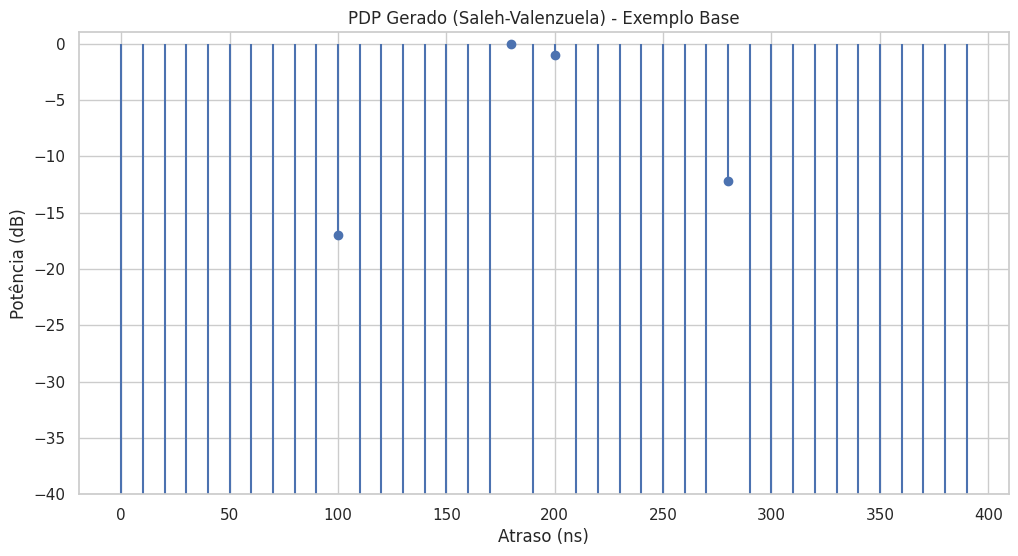

--- 2. Variação: G_cluster (Taxa) Aumentada 5x ---


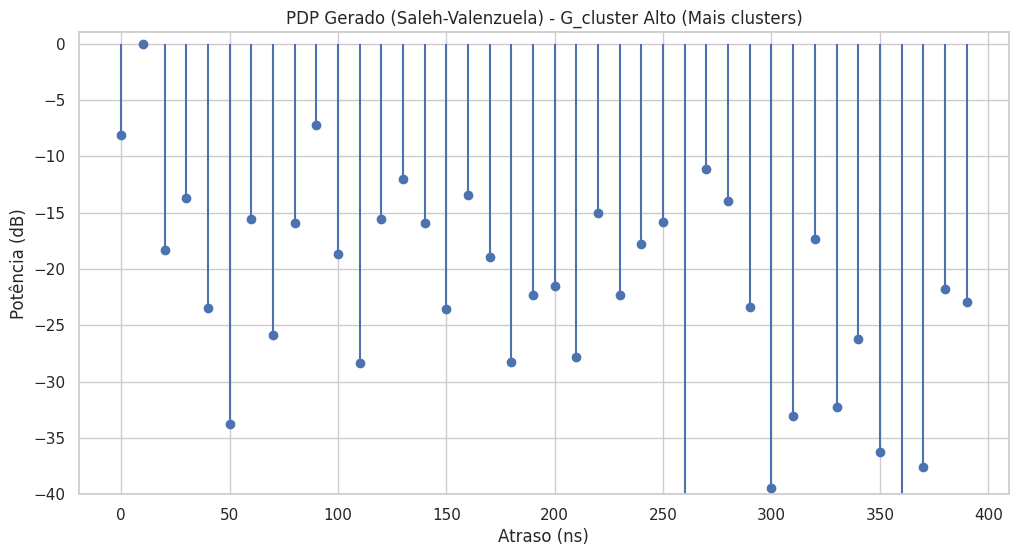

In [61]:
# Parâmetros Base (os mesmos de antes)
params_base = {
    'T_cluster': 100,
    'T_raio': 0.2,
    'G_cluster': 0.02,
    'G_raio': 1.0,
    'max_delay_ns': 400,
    'dt': 10.0
}

# Gerar e plotar o exemplo base
print("--- 1. Exemplo Base (Corrigido) ---")
t, h = gerar_cir_sv(**params_base)
plotar_pdp_sv(t, h, "Exemplo Base")

# --- Variação 1: G_cluster (Taxa) Aumentada 5x ---
print("--- 2. Variação: G_cluster (Taxa) Aumentada 5x ---")
params_var1 = params_base.copy()
params_var1['G_cluster'] = 0.25 # 5x mais rápido

t_v1, h_v1 = gerar_cir_sv(**params_var1)
plotar_pdp_sv(t_v1, h_v1, "G_cluster Alto (Mais clusters)")

# (Você pode continuar com as outras variações, elas agora funcionarão)

--- 2. Variação: G_cluster (Taxa) Aumentada 5x ---


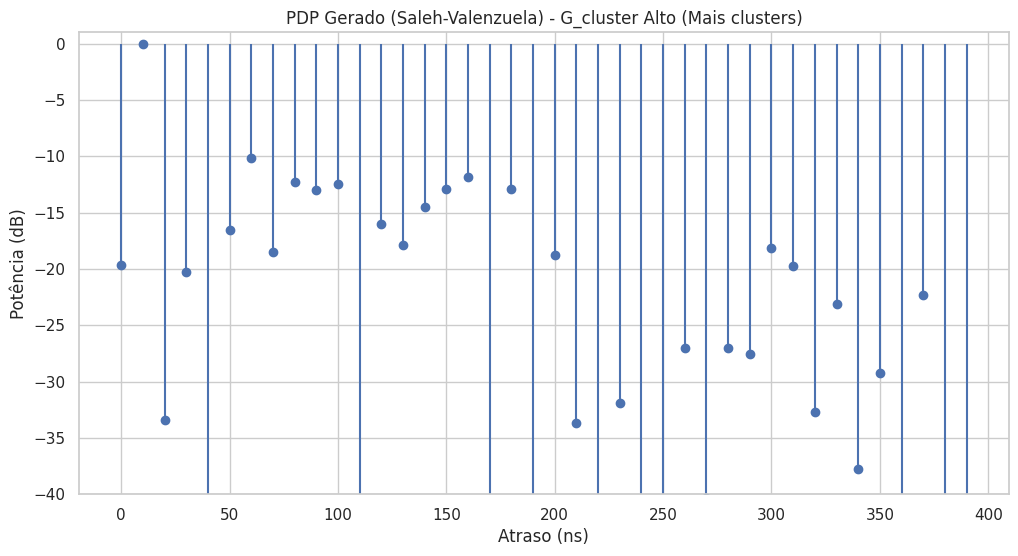

In [62]:
print("--- 2. Variação: G_cluster (Taxa) Aumentada 5x ---")
params_var1 = params_base.copy()
params_var1['G_cluster'] = 0.25 # 5x mais rápido

t_v1, h_v1 = gerar_cir_sv(**params_var1)
plotar_pdp_sv(t_v1, h_v1, "G_cluster Alto (Mais clusters)")

--- 3. Variação: T_cluster (Decaimento) Aumentado 4x ---


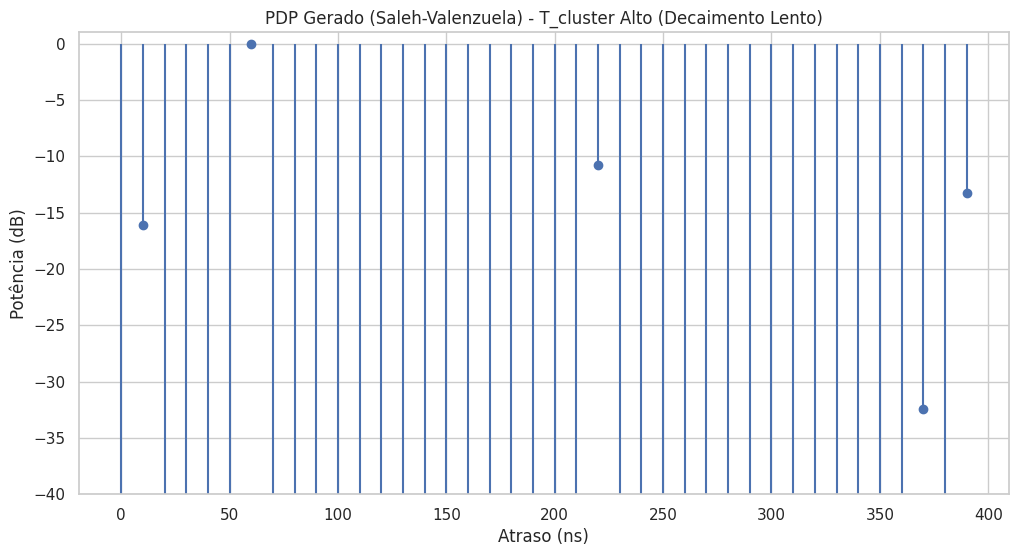

In [63]:
print("--- 3. Variação: T_cluster (Decaimento) Aumentado 4x ---")
params_var2 = params_base.copy()
params_var2['T_cluster'] = 240.0 # 4x mais lento o decaimento

t_v2, h_v2 = gerar_cir_sv(**params_var2)
plotar_pdp_sv(t_v2, h_v2, "T_cluster Alto (Decaimento Lento)")

--- 4. Variação: G_raio (Taxa) Aumentada 5x ---


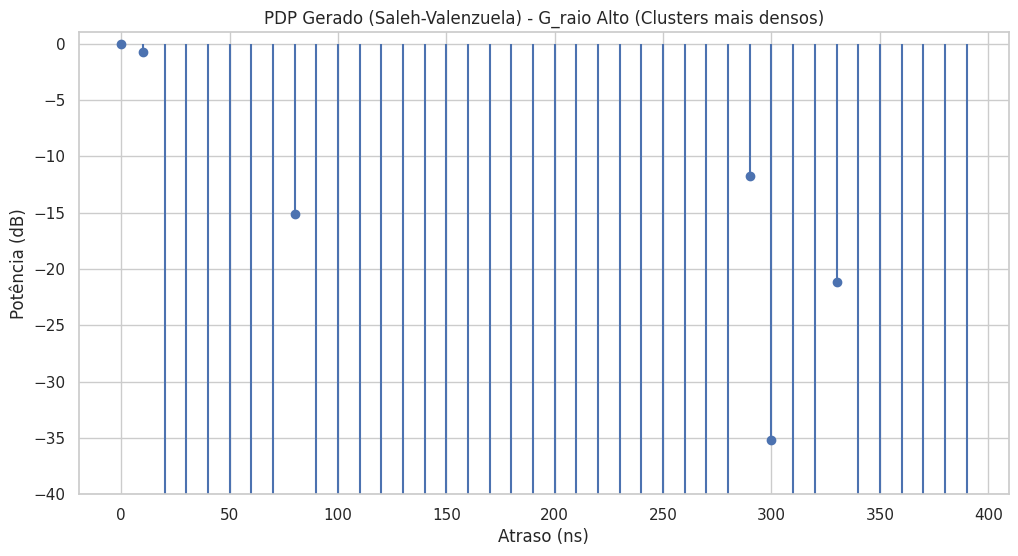

In [64]:
print("--- 4. Variação: G_raio (Taxa) Aumentada 5x ---")
params_var3 = params_base.copy()
params_var3['G_raio'] = 1.0 # 5x mais raios por cluster

t_v3, h_v3 = gerar_cir_sv(**params_var3)
plotar_pdp_sv(t_v3, h_v3, "G_raio Alto (Clusters mais densos)")